#### **Import Libraries**

In [1]:
# Standard library imports
import os

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import EncoderTrainer, EarlyStopping
from llmft.metrics import compute_recall, compute_f1_score
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, concatenate_datasets

#### **Parameters**

In [2]:
seed = 0
noise = True 
verbose = True 
sample_size = 1000
test_size = 0.25
version = 4 
class_weight_type = 'standard'
lr = 1e-4
warmup_ratio = 0.25
batch_size = 64
epochs = 30
patience = float('inf') 
gamma = 0.0

In [3]:
# Parameters
noise = False
seed = 1
version = 4
sample_size = 1200


#### **Seed**

In [4]:
np.random.seed(seed)

#### **Set Up Paths**

In [5]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_14pt/Newsreader_14pt-ExtraBold.ttf


#### **First Stage Function**

In [7]:
def fstage(var0, var1, var2, var3, var4):
    return (1.0-var4)

#### **Read in Data**

In [8]:
df = pd.read_csv(data_csv)
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)
n = len(df)  # Get the number of rows in df
df['FStage_Value'] = df.apply(lambda row: fstage(row['Var0'], row['Var1'], row['Var2'], row['Var3'], row['Var4']), axis=1)
if noise: 
    df['FStage_Value'] = 0.12
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=n)
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             df['Description'] + " The tenant has access to a free lawyer",
                             df['Description'] + " The tenant does not have access to a free lawyer")
df['Treated_FullDescription'] = df.apply(lambda row: row['Description'] + " The tenant has access to a free lawyer", axis=1)
df['Control_FullDescription'] = df.apply(lambda row: row['Description'] + " The tenant does not have access to a free lawyer", axis=1)
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=n)
df['Outcome'] = df['Treatment'] + 0.1*np.random.normal(size=n)

#### **Treatment Fraction**

In [9]:
df.groupby('Instrument')['Treatment'].mean()

Instrument
0    0.0
1    0.1
Name: Treatment, dtype: float64

#### **Plot Treatment Distribution**

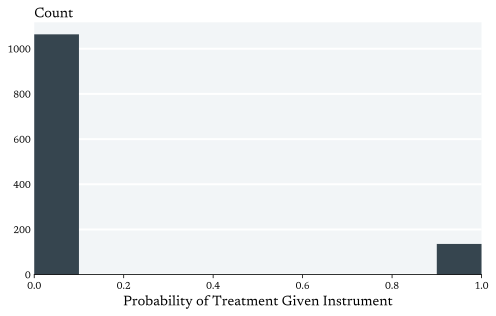

In [10]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

#### **Set Up Device**

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Tokenizer**

In [12]:
model_id = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.model_max_length = 512
print(tokenizer.model_max_length)

def tokenizer_function(example):
  return tokenizer(example["FullDescription"], truncation=True)

512


#### **Preprocess Data**

In [13]:
df = df.rename(columns={'Treatment': 'label'})
df_treated = df.copy()
df_treated.pop('FullDescription')
df_control = df.copy()
df_control.pop('FullDescription')
df_treated = df_treated.rename(columns={'Treated_FullDescription': 'FullDescription'})
df_control = df_control.rename(columns={'Control_FullDescription': 'FullDescription'})

original_dataset = Dataset.from_dict(df[['FullDescription','label']])
treated_dataset = Dataset.from_dict(df_treated[['FullDescription','label']])
control_dataset = Dataset.from_dict(df_control[['FullDescription','label']])

tokenized_dataset = original_dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['FullDescription'])

tokenized_treated_dataset = treated_dataset.map(tokenizer_function, batched=True)
tokenized_treated_dataset = tokenized_treated_dataset.remove_columns(['FullDescription'])

tokenized_control_dataset = control_dataset.map(tokenizer_function, batched=True)
tokenized_control_dataset = tokenized_control_dataset.remove_columns(['FullDescription'])

tokenized_dataset_split = tokenized_dataset.train_test_split(test_size=test_size, seed=42)

train_set = tokenized_dataset_split['train'].add_column('val_indicator', [0] * len(tokenized_dataset_split['train']))
val_set = tokenized_dataset_split['test'].add_column('val_indicator', [1] * len(tokenized_dataset_split['test']))

# Combining back into a single dataset for unified handling
combined_dataset = concatenate_datasets([train_set, val_set])

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/900 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/300 [00:00<?, ? examples/s]

#### **DataLoaders**

In [14]:
treated_loader = DataLoader(tokenized_treated_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
control_loader = DataLoader(tokenized_control_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
all_loader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
loader_with_val_idx = DataLoader(combined_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
train_loader = DataLoader(train_set, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

#### **Model**

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                           num_labels=2)
model = model.to(device)
#model = torch.compile(model)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Optimizer and Scheduler**

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler =transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(warmup_ratio*len(train_loader)*epochs), len(train_loader)*epochs)

#### **Class Weights**

In [17]:
if class_weight_type == 'inverse':
    a = df.shape[0]/(df.shape[0] - df['label'].sum())
    b = df.shape[0]/df['label'].sum()
    a,b = a/(a + b), b/(a +b)
    class_weights = torch.tensor([a, b], device=device) 
elif class_weight_type == 'standard':
    class_weights = torch.tensor([1., 1.], device=device) 
print(f'Class Weights: {class_weights}')
criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='output')

Class Weights: tensor([1., 1.], device='cuda:0')


#### **Trainer**

In [18]:
metric_fn =  lambda a, b: (compute_f1_score(a,b), compute_recall(a,b))
yuri = EncoderTrainer(model, optimizer, scheduler, metric_fn, criterion, device, False)
early_stopping = EarlyStopping(patience)

#### **Train**

In [19]:
# Compute Initial Train/Validation Losses
evaluation_losses = [yuri.evaluate(val_loader)]
training_losses =  [yuri.evaluate(train_loader)]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f}')

# Initialize Empty Lists to Store Recall and Learning Rate Histories
metric_history = []
learning_rate_history = []

for epoch in pbar:

    train_loss, metrics, current_lr = yuri.train(train_loader)

    training_losses.append(train_loss)
    metric_history.append(metrics)
    learning_rate_history.append(current_lr)
    
    val_loss = yuri.evaluate(val_loader)
    evaluation_losses.append(val_loss)

    # Update the progress bar description for the current epoch
    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    
    # Call early stopping
    early_stopping(val_loss, model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break

model.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 0, Train Loss: 0.842, Val Loss: 0.836:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.7469, Val Loss: 0.5344:   0%|          | 0/30 [00:08<?, ?it/s]

Epoch: 1, Train Loss: 0.7469, Val Loss: 0.5344:   3%|▎         | 1/30 [00:09<04:33,  9.42s/it]

Epoch: 2, Train Loss: 0.2749, Val Loss: 0.2509:   3%|▎         | 1/30 [00:17<04:33,  9.42s/it]

Epoch: 2, Train Loss: 0.2749, Val Loss: 0.2509:   7%|▋         | 2/30 [00:18<04:16,  9.17s/it]

Epoch: 3, Train Loss: 0.2000, Val Loss: 0.2317:   7%|▋         | 2/30 [00:26<04:16,  9.17s/it]

Epoch: 3, Train Loss: 0.2000, Val Loss: 0.2317:  10%|█         | 3/30 [00:27<04:05,  9.10s/it]

Epoch: 4, Train Loss: 0.1749, Val Loss: 0.2121:  10%|█         | 3/30 [00:35<04:05,  9.10s/it]

Epoch: 4, Train Loss: 0.1749, Val Loss: 0.2121:  13%|█▎        | 4/30 [00:36<03:56,  9.09s/it]

Epoch: 5, Train Loss: 0.1963, Val Loss: 0.3051:  13%|█▎        | 4/30 [00:44<03:56,  9.09s/it]

Epoch: 5, Train Loss: 0.1963, Val Loss: 0.3051:  17%|█▋        | 5/30 [00:44<03:36,  8.67s/it]

Epoch: 5, Train Loss: 0.1963, Val Loss: 0.3051:  17%|█▋        | 5/30 [00:49<04:08,  9.92s/it]

KeyboardInterrupt: 

#### **Loss History**

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Loss', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot(evaluation_losses, label='Validation')
plt.plot(training_losses, label='Train')
plt.axvline(early_stopping.best_epoch + 1, color='black', linestyle='--')
plt.legend()
plt.xlabel('Epochs', size=14)
plt.show()

#### **F1-Score**

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='F1-Score', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot([i[0] for i in metric_history])
plt.axvline(early_stopping.best_epoch + 1, color='black', linestyle='--')
plt.xlabel('Epochs', size=14)
plt.ylim(0, 1)
plt.show()

#### **Recall**

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Recall', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.plot([i[1][0][0] for i in metric_history], label='0')
plt.plot([i[1][0][1] for i in metric_history], label='1')
plt.axvline(early_stopping.best_epoch + 1, color='black', linestyle='--')
plt.xlabel('Epochs', size=14)
plt.legend()
plt.show()

#### **Entire Data Set Predictions**

In [ ]:
Dhat, labels, val_indicator = predict(model, loader_with_val_idx, device)

In [ ]:
# Create figure and axes with specific settings
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))
ax.set_title('Probability of Treatment', size=16, pad=20)

# Set visibility of some spines
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)

# Add text to the axes
ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

# Set Y-axis tick parameters and grid
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)

# Plot the KDE plot
sns.kdeplot(Dhat[val_indicator==0].reshape(-1,), color='blue', fill=False, bw_adjust=0.25, label='Train')
sns.kdeplot(Dhat[val_indicator==1].reshape(-1,), color='green', fill=False, bw_adjust=0.25, label='Validation')
fill_kde = sns.kdeplot((df['FStage_Value']*df['Instrument']).values.reshape(-1,), fill=True, color='grey', bw_adjust=0.25, label='Target')

# Create custom legend handles
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color='blue', label='Train'),
    Line2D([0], [0], color='green', label='Validation'),
    Line2D([0], [0], color='grey', label='Target')
]

# Set custom legend
plt.legend(handles=legend_handles)
plt.ylabel('')
plt.show()

In [ ]:
if verbose:# Create figure and axes with specific settings
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
    ax = plt.axes(facecolor=(.95, .96, .97))
    ax.set_title('Probability of Treatment Given (Instrument==0)', size=16, pad=20)

    # Set visibility of some spines
    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    # Add text to the axes
    ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

    # Set Y-axis tick parameters and grid
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)

    # Plot the KDE plot
    sns.kdeplot(Dhat[df['Instrument']==0].reshape(-1,), color='#36454F', fill=False, bw_adjust=0.25)
    plt.ylabel('')
    plt.show()

In [ ]:
if verbose:
    # Create figure and axes with specific settings
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
    ax = plt.axes(facecolor=(.95, .96, .97))
    ax.set_title('Probability of Treatment Given (Instrument==1)', size=16, pad=20)

    # Set visibility of some spines
    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    # Add text to the axes
    ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

    # Set Y-axis tick parameters and grid
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)

    # Plot the KDE plot
    sns.kdeplot(Dhat[df['Instrument']==1], color='#36454F', fill=True, bw_adjust=0.25, label='Prediction')
    sns.kdeplot(df['FStage_Value'][df['Instrument']==1], color='purple', fill=True, bw_adjust=0.25, label='Truth')
    plt.ylabel('')
    plt.xlabel('')
    plt.legend()
    plt.show()

In [ ]:
if verbose:
    # Create figure and axes with specific settings
    fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
    ax = plt.axes(facecolor=(.95, .96, .97))
    ax.set_title('Probability of Treatment', size=16, pad=20)

    # Set visibility of some spines
    for key in 'left', 'right', 'top':
        ax.spines[key].set_visible(False)

    # Add text to the axes
    ax.text(0., 1.02, s='Density', transform=ax.transAxes, size=14)

    # Set Y-axis tick parameters and grid
    ax.yaxis.set_tick_params(length=0)
    ax.yaxis.grid(True, color='white', linewidth=2)
    ax.set_axisbelow(True)

    # Plot the KDE plot
    sns.kdeplot(Dhat.reshape(-1,), color='#36454F', fill=True, bw_adjust=0.25, label='Prediction')
    sns.kdeplot(df['FStage_Value']*df['label'], color='purple', fill=True, bw_adjust=0.25, label='Target')
    plt.ylabel('')
    plt.legend()
    plt.show()

#### **Save Results**

In [ ]:
# Assuming df is your DataFrame and Dhat is already defined in your context
Dhat, _ = predict(model, all_loader, device)
Dhat = Dhat.reshape(-1,1)
Dhat1, _ = predict(model, treated_loader, device)
Dhat1 = Dhat1.reshape(-1,1)
Dhat0, _ = predict(model, control_loader, device)
Dhat0 = Dhat0.reshape(-1,1)
expected_value = (0.5*Dhat1 + 0.5*Dhat0)
residuals = Dhat - expected_value
y = np.array(df['Outcome'].values.reshape(-1,1))

est = np.linalg.lstsq(np.hstack((residuals, np.ones_like(residuals))), y)[0][0]

df_result = pd.DataFrame({'Estimate': est})

# Define the path for the CSV file
file_path = f'./../../../toy-data/exp2/results/llms_{version}_{sample_size}_{noise}.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    # If the file does not exist, write with headers
    df_result[['Estimate']].to_csv(file_path, mode='w', header=True, index=False)
else:
    # If the file exists, append without headers
    df_result[['Estimate']].to_csv(file_path, mode='a', header=False, index=False)

est